## Library installation

In [ ]:
!pip install -q "flwr[simulation]" flwr-datasets

In [ ]:
!pip install transformers

In [ ]:
!pip install torch==1.13.1+cpu torchvision==0.14.1+cpu --extra-index-url https://download.pytorch.org/whl/cpu

In [ ]:
!pip install matplotlib

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn

import tqdm

from datasets import Dataset, DatasetDict
from flwr_datasets.partitioner import IidPartitioner

from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader, Subset

from transformers import AutoModel, AutoTokenizer

## Data preprocessing

In [2]:
label_mapping = {
    "Negative": 0,
    "Neutral": 1,
    "Positive": 2,
}

In [3]:
training_data = pd.read_csv("data/twitter_training.csv")
training_data = training_data[training_data.label != "Irrelevant"].drop(columns=["tweet_id", "entity"]).dropna()
training_data["label"] = training_data["label"].map(label_mapping)
training_ds = Dataset.from_pandas(training_data, preserve_index=False)

validation_data = pd.read_csv("data/twitter_validation.csv")
validation_data = validation_data[validation_data.label != "Irrelevant"].drop(columns=["tweet_id", "entity"]).dropna()
validation_data["label"] = validation_data["label"].map(label_mapping)
validation_ds = Dataset.from_pandas(validation_data, preserve_index=False)

In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

pad = tokenizer.pad_token_id

In [5]:
training_ds = training_ds.map(
    lambda s, t: {
        "ids": (encoded := t(s["text"], truncation=True))["input_ids"],
        "attention_mask": encoded["attention_mask"],
    },
    fn_kwargs={"t": tokenizer},
)
validation_ds = validation_ds.map(
    lambda s, t: {
        "ids": (encoded := t(s["text"], truncation=True))["input_ids"],
        "attention_mask": encoded["attention_mask"],
    },
    fn_kwargs={"t": tokenizer},
)

Map:   0%|          | 0/47636 [00:00<?, ? examples/s]

Map:   0%|          | 0/11879 [00:00<?, ? examples/s]

In [6]:
training_ds = training_ds.with_format(type="torch", columns=["ids", "label", "attention_mask"])
validation_ds = validation_ds.with_format(type="torch", columns=["ids", "label", "attention_mask"])

In [7]:
DatasetDict({"train": training_ds, "test": validation_ds})

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'ids', 'attention_mask'],
        num_rows: 47636
    })
    test: Dataset({
        features: ['label', 'text', 'ids', 'attention_mask'],
        num_rows: 11879
    })
})

In [8]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    def collate_fn(batch):
        batch_ids = nn.utils.rnn.pad_sequence([i["ids"] for i in batch], padding_value=pad_index, batch_first=True)
        batch_label = torch.stack([i["label"] for i in batch])
        batch_mask = nn.utils.rnn.pad_sequence([i["attention_mask"] for i in batch], padding_value=pad_index, batch_first=True)
        
        return {
            "ids": batch_ids,
            "label": batch_label,
            "attention_mask": batch_mask,
        }
    
    dl = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle
    )
    
    return dl

training_dl = get_data_loader(training_ds, 32, pad, shuffle=True)
validation_dl = get_data_loader(validation_ds, 32, pad)

## Model definition

In [9]:
class Transformer(nn.Module):
    def __init__(self, transformer, num_classes, freeze):
        super().__init__()
        
        self.transformer = transformer
        
        hidden_dim = transformer.config.hidden_size
        
        self.fc = nn.Linear(hidden_dim, num_classes)
        
        if freeze:
            for param in self.transformer.parameters():
                param.requires_grad = False

    # ids: [batch size, seq len]
    def forward(self, ids: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        output = self.transformer(ids, output_attentions=True, attention_mask=attention_mask)
        
        # [batch size, seq len, hidden dim]
        hidden_state = output.last_hidden_state
        
        # [batch size, n heads, seq len, seq len]
        # attention = output.attentions[-1]
        
        cls_hidden = hidden_state[:, 0, :]

        # [batch size, output dim]
        prediction = self.fc(torch.tanh(cls_hidden))
        
        return prediction

In [10]:
tf = AutoModel.from_pretrained("bert-base-uncased")

model = Transformer(tf, num_classes=3, freeze=False)

## Loading from backup
### Checkpoint loading

In [11]:
checkpoint = torch.load("model/checkpoint.pth")

In [12]:
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

### Trained model loading

In [ ]:
model.load_state_dict(torch.load("model/trained_model.pth", weights_only=True))

## Model configuration

In [13]:
num_parameters = sum(value.numel() for value in model.state_dict().values())
print(f"{num_parameters = }")

num_parameters = 109484547


In [14]:
criterion = torch.nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = criterion.to(device)

print(model)

Transformer(
  (transformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

## Training and evaluation

In [15]:
def get_accuracy(prediction, label):
    #batch_size, _ = prediction.shape
    #predicted_classes = prediction.argmax(dim=-1)
    #correct_predictions = predicted_classes.eq(label).sum()
    #accuracy = correct_predictions / batch_size

    predicted_classes = prediction.argmax(dim=-1).cpu().numpy()
    actual_labels = label.cpu().numpy()
    
    return accuracy_score(actual_labels, predicted_classes)

def get_precision(prediction, label):
    predicted_classes = prediction.argmax(dim=-1).cpu().numpy()
    actual_labels = label.cpu().numpy()
    
    return precision_score(actual_labels, predicted_classes, average="macro", zero_division=0)

def train(net, data_loader, optimizer):
    net.train()
    
    batch_losses = []
    batch_accuracies = []
    batch_precisions = []
    
    for batch in tqdm.tqdm(data_loader, desc="Training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        
        prediction = net(ids, attention_mask)
        
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        precision = get_precision(prediction, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss.item())
        batch_accuracies.append(accuracy)
        batch_precisions.append(precision.item())
        
    return np.mean(batch_losses), np.mean(batch_accuracies), np.mean(batch_precisions)

def test(net, data_loader):
    net.eval()
    
    batch_losses = []
    batch_accuracies = []
    batch_precisions = []
    
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="Evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            
            prediction = net(ids, attention_mask)
            
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            precision = get_precision(prediction, label)
            
            batch_losses.append(loss.item())
            batch_accuracies.append(accuracy)
            batch_precisions.append(precision.item())
            
    return np.mean(batch_losses), np.mean(batch_accuracies), np.mean(batch_precisions)

def run_centralized(
        training_loader: DataLoader,
        validation_loader: DataLoader,
        epochs: int,
        learning_rate: float,
        save_checkpoints: bool,
        first_epoch: int = 0,
        optimizer_state_dict = None,
):
    losses = []
    accuracies = []
    precisions = []
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    if optimizer_state_dict:
        optimizer.load_state_dict(optimizer_state_dict)

    for epoch in range(first_epoch, epochs):
        print(f"Training epoch #{epoch + 1}:")
        
        train(model, training_loader, optimizer)

        loss, accuracy, precision = test(model, validation_loader)
        
        losses.append(loss)
        accuracies.append(accuracy)
        precisions.append(precision)

        print(f"{loss = }")
        print(f"{accuracy = }")
        print(f"{precision = }")
        
        if save_checkpoints:
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": losses,
                "accuracy": accuracies,
                "precision": precisions,
            }, "model/checkpoint.pth")
            
    return losses, accuracies, precisions

In [16]:
n = 5
lr = 1e-5

l, a, p = run_centralized(
    training_dl,
    validation_dl,
    epochs=n,
    learning_rate=lr,
    save_checkpoints=True,
    first_epoch=checkpoint["epoch"] + 1,
    optimizer_state_dict=checkpoint["optimizer_state_dict"],
)

Training epoch #2:


Evaluating...: 100%|██████████████████████████████████████████████████████████████████| 372/372 [09:51<00:00,  1.59s/it]


loss = 0.3089282169277149
accuracy = 0.8901209677419355
precision = 0.8897741325380186
Training epoch #3:


Evaluating...: 100%|██████████████████████████████████████████████████████████████████| 372/372 [09:47<00:00,  1.58s/it]


loss = 0.24331967240000413
accuracy = 0.9160786290322581
precision = 0.914773056449606
Training epoch #4:


Evaluating...: 100%|██████████████████████████████████████████████████████████████████| 372/372 [09:48<00:00,  1.58s/it]


loss = 0.22715063481397615
accuracy = 0.9260752688172043
precision = 0.9262976493561109
Training epoch #5:


Evaluating...: 100%|██████████████████████████████████████████████████████████████████| 372/372 [09:47<00:00,  1.58s/it]


loss = 0.23577164921145047
accuracy = 0.930695564516129
precision = 0.9293407883639541


In [17]:
torch.cuda.empty_cache()

In [18]:
checkpoint = torch.load("model/checkpoint.pth")

l = checkpoint["loss"]
a = checkpoint["accuracy"]
p = checkpoint["precision"]

### Predictions on 10 random samples

In [23]:
reverse_mapping = {v: k for k, v in label_mapping.items()}

random_indices = random.sample(range(0, len(validation_ds)), 10)

texts = [validation_ds['text'][i] for i in random_indices]
labels = [validation_ds['label'][i].item() for i in random_indices]
predictions = []

prediction_sample = get_data_loader(Subset(validation_ds, random_indices), 1, pad)

In [24]:
model.eval()

with torch.no_grad():
    i = 0
    
    for batch in prediction_sample:
        ids = batch["ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        prediction = model(ids, attention_mask)
        predicted_class = prediction.argmax(dim=-1)

        predictions.append(predicted_class.item())

In [25]:
for item in list(zip(texts, [reverse_mapping[l] for l in labels], [reverse_mapping[p] for p in predictions])):
    print(item)

('I like my meals paired with a real nice round of Fortnite.', 'Positive', 'Positive')
('A Nerf pistol painted to look like a gun', 'Neutral', 'Neutral')
('When is FIFA 21 coming out? Not that I’m gonna buy this shitty game made of greedy developers who has little but money playing their hand, just curious:)', 'Neutral', 'Neutral')
("Call of duty this thing is broken have done it and nothing is unlocking or counting towards it what's going broke", 'Negative', 'Negative')
('@ScottWapnerCNBC I heard you were... a real fan of admitting the truth. @ReformedBroker is me a @ ^ %', 'Neutral', 'Neutral')
('Top 5 Best Role-playing games. bit.ly / 3cYVU5P', 'Positive', 'Positive')
('Fix you fucking shit game ubi @ Rainbow6Game @ Ubisoft pic.twitter.com / xyFtdKvIsq', 'Negative', 'Negative')
('mm hi Amazon I think you’ve breached UK GDPR from selling my child’s data. is your employer responsible for data selling in the UK?', 'Negative', 'Negative')
('I absolutely love the new one', 'Positive', 'P

### Model saving

In [26]:
torch.save(model.state_dict(), "model/trained_model.pth")

In [33]:
#0.8901209677419355
checkpoint["loss"]

[0.3089282169277149,
 0.24331967240000413,
 0.22715063481397615,
 0.23577164921145047]

### Evaluation graph

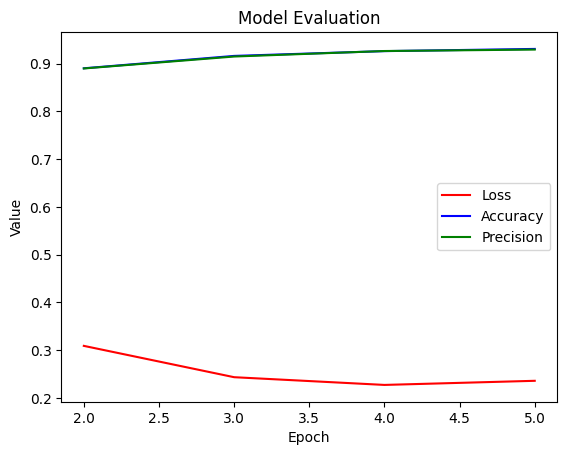

In [32]:
epoch_rng = range(2, n + 1)

plt.plot(epoch_rng, l, label="Loss", color="red")
plt.plot(epoch_rng, a, label="Accuracy", color="blue")
plt.plot(epoch_rng, p, label="Precision", color="green")

plt.xlabel("Epoch")
plt.ylabel("Value")

plt.title("Model Evaluation")
plt.legend()
plt.show()

## Federated learning (TODO)

In [ ]:
partitioner = IidPartitioner(num_partitions=10)
partitioner.dataset = training_ds

partitioner.load_partition(partition_id=0)

In [ ]:
from flwr_datasets.visualization import plot_label_distributions

fig, ax, df = plot_label_distributions(
    partitioner,
    label_name="label",
    plot_type="bar",
    size_unit="absolute",
    partition_id_axis="x",
    legend=True,
    verbose_labels=False,
    max_num_partitions=10,
    title="Label Distribution Per Partition",
)